In [1]:
import numpy as np
from matplotlib import pyplot as plt

import sympy as smp

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

In [2]:
def generate_problem(n, p, q, sigma, dist='identity', dist_params=None):
    
    if dist_params is None:
        dist_params = {}
        
    if dist == 'identity':
        Sig = np.eye(p)
        X = np.random.randn(n, p + q)
        X_test = np.random.randn(n, p + q)
    elif dist == 'rho':
        rho = dist_params['rho'] if 'rho' in dist_params else 0.5
        Sig = (1 - rho) * np.eye(p) + rho * np.ones((p, p))
        _, Q = np.linalg.eigh(Sig)
        X = np.random.randn(n, p + q) @ Q.T
        X_test = np.random.randn(n, p + q) @ Q.T
    elif dist == 'logspace':
        lowvar = dist_params['lowvar'] if 'lowvar' in dist_params else 1e-4
        Q = dist_params['Q'] if 'Q' in dist_params else None
        variances = np.random.permutation(np.logspace(0, np.log10(lowvar), p + q))
        stds = np.sqrt(variances)
        if Q is None:
            Sig = np.diag(variances[:p])
            X = np.random.randn(n, p + q) * stds[None, :]
            X_test = np.random.randn(n, p + q) * stds[None, :]
        else:
            if Q == 'random':
                A = np.random.randn(p, p)
                _, Q = np.linalg.eigh(A + A.T)
            Sig = Q @ (variances[:p, None] * Q.T)
            X = (np.random.randn(n, p + q) * stds[None, :]) @ Q.T
            X_test = (np.random.randn(n, p + q) * stds[None, :]) @ Q.T
    
    beta = np.random.randn(p) / np.sqrt(p)
    y = X[:, :p] @ beta + sigma * np.random.randn(n)
    
    return X, y, beta, X_test, Sig


def risk(beta, beta_hat, Sig=None, X_test=None):
    
    if Sig is None:
        if X_test is None:
            raise ValueError('Data covariance or test data must be provided.')
        n, p = X_test.shape
        Sig = X_test.T @ X_test / n
    
    beta_delta = beta - beta_hat
    return beta_delta @ (Sig @ beta_delta)


def ensemble_risk_ij(intersection_size, complement_intersection_size, gamma, sigma, eta=1):
    
    return complement_intersection_size * (1 + intersection_size * gamma / (eta - intersection_size * gamma)) + intersection_size * gamma * sigma**2 / (eta - intersection_size * gamma)


def ensemble_risk(alpha, gamma, sigma, k=None, eta=1):
    
    if k is None:
        return ensemble_risk_ij(alpha**2, (1 - alpha)**2, gamma, sigma, eta=1)
    else:
        return (1 - 1/k) * ensemble_risk_ij(alpha**2, (1 - alpha)**2, gamma, sigma, eta=1) + 1/k * ensemble_risk_ij(alpha, 1-alpha, gamma, sigma, eta=eta)


def ensemble_optimal_alpha(gamma, sigma, k=None, eta=None):
    
    if k is None:
    
        a = 1
        b = - (1 / gamma + 1 + sigma**2)
        c = 1 / gamma
        alpha = (-b - np.sqrt(b**2 - 4 * a * c)) / (2 * a)

        return alpha

    else:
        if eta is None:
            eta = 1
            
        alpha = smp.symbols('a', real=True)
        r = ensemble_risk(alpha, gamma, sigma, k, eta)
        drdalpha = smp.diff(r, alpha)
        numerator, _ = smp.fraction(smp.simplify(drdalpha))
        coeffs = smp.Poly(numerator).coeffs()
        roots = [np.abs(r) for r in np.roots(coeffs) if np.angle(r) < 1e-2 and 0 <= np.abs(r) <= 1/gamma]
        roots += [0, 1/gamma - 1e-6]
        
        return min(roots, key=lambda x: ensemble_risk(x, gamma, sigma, k, eta))


def ridge_optimal_risk(gamma, sigma):
    
    dobriban = 1 / 2 * (1 + (gamma - 1) / gamma / sigma**2 + np.sqrt((1 - (gamma - 1) / gamma / sigma**2)**2 + 4 / sigma**2))
    return (dobriban - 1) * sigma**2


class EnsembleOLS(BaggingRegressor):
    
    def __init__(self, fit_intercept=False, *args, **kwargs):
        
        self.fit_intercept = fit_intercept
        
        kwargs.update({
            'base_estimator': LinearRegression(fit_intercept=fit_intercept),
            'bootstrap': False,
            'bootstrap_features': False
        })
        super().__init__(*args, **kwargs)
    
    def get_coefs(self):
        
        p = self.n_features_
        beta = np.zeros(p)
        
        for features, estimator in zip(self.estimators_features_, self.estimators_):
            
            beta[features] += estimator.coef_ / len(self.estimators_)
        
        return beta

In [3]:
n = 200
gammas = [0.5, 1, 2]
sigma = 1
dist = 'identity'
dist_params = None
n_trials = 50
ks = np.unique(np.logspace(0, 3, dtype=int))

risks_ridge = np.zeros(len(gammas))
risks_ensemble = np.zeros((len(gammas), n_trials, len(ks)))
risks_ensemble_eta = np.zeros((len(gammas), n_trials, len(ks)))

for t, gamma in enumerate(gammas):
    
    print(gamma, end='')

    p = int(gamma*n)

    alpha = ensemble_optimal_alpha(gamma, sigma)
    risks_ridge[t] = ridge_optimal_risk(gamma, sigma)
    r_ensemble = ensemble_risk(alpha, gamma, sigma)

    eta = min(1.0, 1.1*alpha*gamma)


    for i in range(n_trials):
        print('.', end='')

        X, y, beta, X_test, Sig = generate_problem(n, p, 0, sigma, dist, dist_params)

        ens_ols = EnsembleOLS(n_estimators=1, warm_start=True, max_samples=1.0, max_features=alpha, n_jobs=-1)
        ens_ols_eta = EnsembleOLS(n_estimators=1, warm_start=True, max_samples=eta, max_features=alpha, n_jobs=-1)

        for j, k in enumerate(ks):
            ens_ols.n_estimators = k
            ens_ols.fit(X, y)
            beta_hat = ens_ols.get_coefs()
            risks_ensemble[t, i, j] = risk(beta, beta_hat, Sig)

            ens_ols_eta.n_estimators = k
            ens_ols_eta.fit(X, y)
            beta_hat = ens_ols_eta.get_coefs()
            risks_ensemble_eta[t, i, j] = risk(beta, beta_hat, Sig)
    
    print('')

np.savez('risk_versus_k.npz', gammas=gammas, ks=ks, risks_ensemble=risks_ensemble, risks_ensemble_eta=risks_ensemble_eta, risks_ridge=risks_ridge)

0.5..................................................
1..................................................
2..................................................


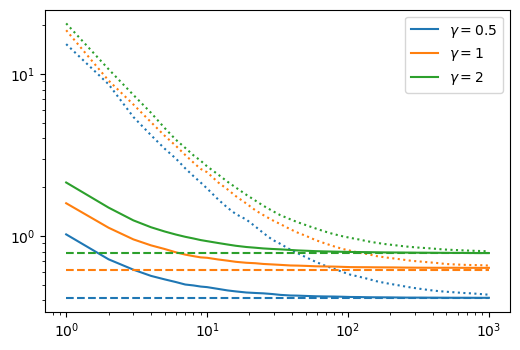

In [4]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(dpi=100)

for t, gamma in enumerate(gammas):
    plt.loglog(ks, risks_ensemble[t, :, :].mean(0), color=colors[t], label=r'$\gamma=%g$' % gamma)
    plt.plot(ks, risks_ensemble_eta[t, :, :].mean(0), ':', color=colors[t])
    plt.plot(ks, [risks_ridge[t]] * len(ks), '--', color=colors[t])

plt.legend() 
plt.show()

In [9]:
n = 200
gamma = 2
p = int(gamma*n)
sigmas = np.logspace(-1, 1, 21)
dist = 'identity'
dist_params = None
ks = [20, 100, 500]
n_trials = 100

risks_ridge = np.zeros(len(sigmas))
risks_ensemble = np.zeros((len(sigmas), n_trials, len(ks)))

for t, sigma in enumerate(sigmas):
    
    print(sigma, end='')

    alpha = ensemble_optimal_alpha(gamma, sigma)
    risks_ridge[t] = ridge_optimal_risk(gamma, sigma)

    for i in range(n_trials):
        
        print('.', end='')

        for j, k in enumerate(ks):
            X, y, beta, X_test, Sig = generate_problem(n, p, 0, sigma, dist, dist_params)
            ens_ols = EnsembleOLS(n_estimators=k, warm_start=False, max_samples=1.0, max_features=alpha, n_jobs=-1)
            ens_ols.fit(X, y)
            beta_hat = ens_ols.get_coefs()
            risks_ensemble[t, i, j] = risk(beta, beta_hat, Sig)
    
    print('')

np.savez('risk_versus_sigma.npz', sigmas=sigmas, ks=ks, risks_ensemble=risks_ensemble, risks_ridge=risks_ridge)

0.1....................................................................................................
0.12589254117941673....................................................................................................
0.15848931924611134....................................................................................................
0.19952623149688797....................................................................................................
0.251188643150958....................................................................................................
0.31622776601683794....................................................................................................
0.3981071705534973....................................................................................................
0.5011872336272724....................................................................................................
0.6309573444801934..........................................

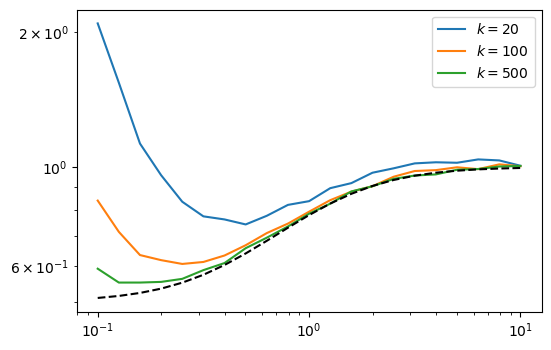

In [10]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(dpi=100)

for j, k in enumerate(ks):
    plt.loglog(sigmas, risks_ensemble[:, :, j].mean(1), color=colors[j], label='$k=%d$' % k)
plt.plot(sigmas, risks_ridge, '--', color='black')

plt.legend()
plt.show()

In [7]:
n = 200
gamma = 2
p = int(gamma*n)
sigmas = np.logspace(-1, 1, 21)
dist = 'identity'
dist_params = None
ks = [20, 100, 500]
n_trials = 100

risks_ridge = np.zeros(len(sigmas))
risks_ensemble = np.zeros((len(sigmas), n_trials, len(ks)))

for j, k in enumerate(ks):
    print(k)
    
    for t, sigma in enumerate(sigmas):

        print(sigma, end='')

        alpha = ensemble_optimal_alpha(gamma, sigma, k)
        if alpha*p < 1:
            alpha = 1
        risks_ridge[t] = ridge_optimal_risk(gamma, sigma)

        for i in range(n_trials):

            print('.', end='')

            X, y, beta, X_test, Sig = generate_problem(n, p, 0, sigma, dist, dist_params)

            ens_ols = EnsembleOLS(n_estimators=k, warm_start=False, max_samples=1.0, max_features=alpha, n_jobs=-1)

            ens_ols.fit(X, y)
            beta_hat = ens_ols.get_coefs()
            risks_ensemble[t, i, j] = risk(beta, beta_hat, Sig)

        print('')

np.savez('risk_versus_sigma_optimal_alpha.npz', sigmas=sigmas, ks=ks, risks_ensemble=risks_ensemble, risks_ridge=risks_ridge)

20
0.1....................................................................................................
0.12589254117941673....................................................................................................
0.15848931924611134....................................................................................................
0.19952623149688797....................................................................................................
0.251188643150958....................................................................................................
0.31622776601683794....................................................................................................
0.3981071705534973....................................................................................................
0.5011872336272724....................................................................................................
0.6309573444801934.......................................

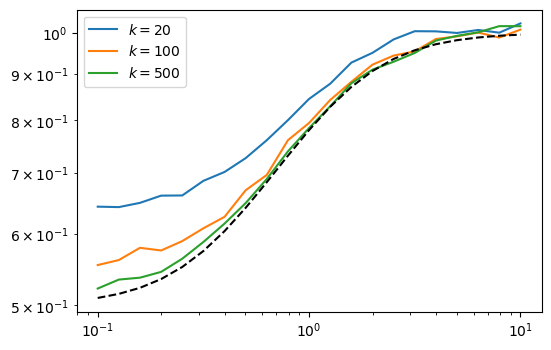

In [8]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(dpi=100)

for j, k in enumerate(ks):
    plt.loglog(sigmas, risks_ensemble[:, :, j].mean(1), color=colors[j], label='$k=%d$' % k)
plt.plot(sigmas, risks_ridge, '--', color='black')

plt.legend()
plt.show()